<a id='Top'></a>
# Chatting with Yourself, A 15-688 Project on Chatbots

**Jeff Curran, CMU '19**  
**Dan Chen, CMU '19**  
**Shayne Bement, CMU '19**  

*Updated: 12/10/19*

Chatbots are becomming more and more commonplace in today's world. A 2019 [report by Business Insider](https://www.businessinsider.com/80-of-businesses-want-chatbots-by-2020-2016-12) estimates that by the end of 2020, 80% of enterprises in developed nations will utilize chatbots in some aspect of their operation strategy. We have seen this in the form of automated customer service representatives and automated Human Resource tools. In a recent [TTEC article](https://www.ttec.com/articles/what-expect-rise-chatbots), Jason Hong, a professor in CMU's School of Computer Science, reveals that many messaging apps are beginning to expand on their services by incorporating chatbot functionality to better engage their users. Similarly, there is [irrefutable evidence](https://www.geekwire.com/2018/will-rogue-ai-chatbots-emerge-2019/) that the presence of malicious chatbots across the web is also on the rise. These malevolent bots do their best to impersonate companies' customer service agents,as well as friends and family, to trick users into revealing personal information that can result in serious financial repercussions. 

As chatbots, good and bad, are becoming more prevalent in our society it’s important as data scientists that we understand how these bots are made and how we can prevent their application for pernicious purposes. The main goal of this project is to develop a chatbot verification system that analyzes the inputs given by a user or other entity to determine if they are actually who they claim to be. Read on to learn how to create your own dataset, explore interesting insights from that dataset, predict the sentiment of your chat history, and finally develop a series of model's for use as a verification system.

Other Sources:
[The human interaction at the center of this pattern is a growing concern for banking companies who see chatbots as a potential solution](https://aibusiness.com/chatbots-finance-combat-fraud/)


### [Part 1: Finding and Parsing Your Chat History](#Part1)

While this was not the "complicated" part of the project, it was still very time consuming to build a conversation corpus from our own historical dialogue. Luckily, we recently had some practice with regular expressions, so we were able to put together a series of functions to parse Facebook Messanger, Android SMS, Google Hangouts, and WhatsApp conversations, our main methods of communication.

### [Part 2: Exploring Our Conversation History](#Part2)

Once the data was downloaded, cleaned, and merged we began to draw insights about our conversation patterns. The EDA was useful to identify trends in our unique speaking behaviors and spot issues with the merging process.

### [Part 3: Analyzing Conversation Sentiment](#Part3)

We can use the corpus of data that we've developed to investigate patterns in how we address those we're speaking to and draw insight into whether we should adjust how we communicate with others. This can also be potentially useful when analyzing if someone is trying to impersonate another based off their tone.

### [Part 4: Verifying the Validity of a Speaker](#Part4)

In Part 4 we arrive at the meat of our problem. With Chatbots gaining more and more power over our sensitive personal information, institutions need to be sure that the person interacting with the chatbot is really a verified user. Credentials can be stolen, so using our speaker verification tool will allow institutions to add another layer of protection for their users. In practice, this would mean a chatbot will analyze the inputs of a user and cross-reference those inputs with historical data to ensure that the individual is really who they say they are. In this project, we used our compiled to train a variety of models for text source classification. To replicate this step of the process, look for the iceroot.pkl and the gnomefreak.pkl to add two additional personas to the models.

### [Part 5: Live Testing our Models](#Part5)

In Part 5 we put all the work to use by allowing users to enter their own text input and see which of the training datasets that input most identifies with. Try it out yourself!

Let's start by importing the necessary packages. Use the **'requirements.txt'** file found on this repo to install the correct versions of each package.

NOTE: As of June, 2019 Tensorflow version 2.0 is out, but we found that it still has some bugs to be worked out, so we decided to use legacy Tensorflow instead. Everything in this tutorial is compatible with version 1.15rc2, though we may update everything to use version 2.0 at a future date

As with all projects, we begin with our import statements. We tried to separate these imports into groups to aid the reader's understanding of why we need each particular import.

In [1]:
### Useful Imports
import pandas as pd
import numpy as np
from datetime import timedelta
import datetime
import os
from collections import Counter


### Part 1: Capturing Data ###
## For WhatsApp
import re

## For SMS
from xml.dom import minidom

## For Facebook
import glob
import json
from pathlib import Path

### Part 2: EDA ###
import matplotlib
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

### Part 3: Sentiment Analysis ###
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

### Part 4: Speaker Verification ###
#** As Above **#

### Part X: Model Building ###
# import tensorflow as tf
# from random import randint

os.chdir(r'C:\Users\Punst\Documents\CMU\Courses\Practical Data Science\Midterm Tutorial\Data')


<a id='Part1'></a>
## Part 1: Finding and Parsing Your Chat History  
[*top of page*](#Top)  

When approaching this project the goal was to capture as much of our message history as possible. We collected the sources that contain most of our conversations, but we struggled to develop an simple way to separate out the group dynamics involved with a multi-participant message thread so we decided for the first attempt at this project that we would not include any group conversations in the corpus at all. This drastically reduced the number of conversations available to us (we're big fans of talking in groups it seems!), but we're hopeful that we can include them in a meaningful way in the future.

Due to the sensitive nature of this data we can't provide our own datasets to work with, so we have brought in a [publicly available dataset](https://www.kaggle.com/rtatman/ubuntu-dialogue-corpus) that captures conversations surrounding the Ubuntu operating system. We show you how to capture three users from this dataset and encourage you to follow along and generate your own dialogue corpus! To ensure compatibility with the parser functions I have included examples of what the data looks like from each data source.

*If you would like to simply run this notebook with the pre-generated publicly available users feel free to skip ahead to Part 2!*

### Part 1.1 Capturing WhatsApp Data

If you use WhatsApp, it is fairly straight forward to capture these messages via some fancy regex. To download these conversations you have to go to your WhatsApp and choose "Export chat" for each of the conversations you want to capture. Luckily, we don't use this app to communicate "1-on-1" very often so we only had to go through this process a few times. You can find more detailed instructions on how to export WhatsApp chats from their [FAQ](https://faq.whatsapp.com/en/android/23756533/?category=5245251). When you have completed this step, put all of the .txt files together in a directory and point the below code at that directory to create the conversation Dataframe: 'person_df'.

In [2]:
##### WhatsApp Extraction Functions #####
'''
An example WhatsApp exchange:
10/23/18, 4:19 PM - [Person]: my python class got cancelled. So if you and the mind freak are free we could try and do a gloomhaven thing tonight
10/23/18, 4:22 PM - Shayne: This just made my day
'''

def continuation(s):
    '''
    Checks if the current line is wrap around text of a previous message by looking for "added member to group"-type line
    '''
    pattern = "^((?:[0-2][0-9]|[0-9])\/(?:[0-3][0-9]|[0-9])\/[0-3][0-9]), ((?:[0-2][0-9]|[0-9]):(?:[0-9][0-9]|[0-9]) [AP][M]) -"
    result = re.match(pattern, s)
    if result:
        return False
    return True
    
def messageCheck(s):
    '''
    Checks if the current line is a valid message
    '''
    pattern = "^((?:[0-2][0-9]|[0-9])\/(?:[0-3][0-9]|[0-9])\/[0-3][0-9]), ((?:[0-2][0-9]|[0-9]):(?:[0-9][0-9]|[0-9]) [AP][M]) - (.*?): (.*)"
    result = re.match(pattern, s)
    if result:
        return True
    return False

def getMessageComponents(s):
    '''
    Returns the Date, Time, Author, and Message from the group
    '''
    pattern = re.compile("^((?:[0-2][0-9]|[0-9])\/(?:[0-3][0-9]|[0-9])\/[0-3][0-9]), ((?:[0-2][0-9]|[0-9]):(?:[0-9][0-9]|[0-9]) [AP][M]) - (.*?): (.*)")
    m = re.findall(pattern, s)
    date = m[0][0]
    time = m[0][1]
    author = m[0][2]
    message = m[0][3]
    return date, time, author, message

def whatsAppParser(filename, my_name):
    '''
    This function takes an exported WhatsApp file and converts it to a pandas dataframe with the correct ordering of columns.
    (The correct column order is set by the source agnostic responseDictionaryExtractor function below)
    
    @Parameters:
    filename - The filename of the WhatsApp .txt file
    
    @Returns:
    person_df - The dataframe capturing all of the correspondance between myself and [Person] via WhatsApp
    '''
    ### Creating the lists to capture the parsed data
    date_list = []
    time_list = []
    author_list = []
    message_list = []
    
    file_text = open(filename, encoding='UTF-8')

    for line in file_text:
        line.strip()
        line = line.strip('\n')
        if continuation(line):
            ## add line to end of last message
            message_list[len(message_list)-1] += " " + line
        if not messageCheck(line):
            continue

        date, time, author, message = getMessageComponents(line)
        date_list.append(date)
        time_list.append(time)
        author_list.append(author)
        message_list.append(message)
    file_text.close()
    
    other_party = next(iter(set(author_list) - {my_name}))
    
    person_df = pd.DataFrame(list(zip(date_list, time_list, author_list, message_list)),
                             columns=['date', 'time', 'sender', 'message']) 
    
    person_df['datetime'] = person_df['date'] + " " + person_df['time']
    person_df['datetime'] = pd.to_datetime(person_df['datetime'])
    person_df['my_message'] = np.where(person_df['sender'] == my_name, 1, 0)
    person_df.drop(columns=['date', 'time'], inplace=True)
    person_df.sort_values(by=['datetime'])
    person_df.rename(columns={'datetime':'date', 'message':'body'}, inplace=True)
    person_df['recipient'] = np.where(person_df['my_message'] == 1, other_party, my_name)
    person_df = person_df[['date', 'body', 'my_message', 'sender', 'recipient']]
    
    return person_df
##### End WhatsApp Extraction Functions #####

### Part 1.2 Capturing Android SMS Data

To download your Android SMS data you can use a free Android app "SMS Backup & Restore." You can find more detailed instructions on how to use this app to download your SMS history [here](https://www.androidcentral.com/how-back-up-restore-text-messages-android). This app will give you the option to backup the entirety of your text history and then produce a .xml file which you can then move to a local directory and apply the below functions to it. As a person that doesn't purchase a new phone very often I (Shayne) was lucky to get a large portion of my corpus from this source, but I imagine mileage will vary depending on how often people still use plain old SMS texts.   

*NOTE: Please review the necessary app permisions carefully before downloading and installing this app!*

In [3]:
##### SMS Extraction Functions #####
'''
An example exchange:
<sms protocol="0" address="8888888888" date="1492284333553" type="2" ... body="What organization was your Zambia internship going to be with?" ... />
<sms protocol="0" address="8888888888" date="1492285511430" type="1" ... body="it was through bu " ... />
'''

def processPhoneNumber(df):
    '''
    Takes a dataframe with a phone number column and processes that column
    @Parameters: a dataframe with a column labelled 'phone_number'
    @Return: a dataframe with a cleansed 'phone_number_column'
    '''
    def cleanPhoneNumber(phone_number):
        ''' Removes the international code from phone numbers if present '''
        if len(phone_number) > 10:
            return phone_number[1:]
        return phone_number
    
    ### removes "spam" phone numbers
    df = df[df['phone_number'].apply(lambda x: len(x) > 9)]
    
    ### Cleans the phone number column
    df['phone_number'] = df['phone_number'].str.replace('(', '')
    df['phone_number'] = df['phone_number'].str.replace(')', '')
    df['phone_number'] = df['phone_number'].str.replace('+', '')
    df['phone_number'] = df['phone_number'].str.replace('-', '')
    df['phone_number'] = df['phone_number'].str.replace(' ', '')
    df['phone_number'] = df['phone_number'].str.replace(',', '')
    df['phone_number'] = df['phone_number'].apply(cleanPhoneNumber)
    
    return df

def smsParser(filename, my_name):
    '''
    This function takes the filename of the output from the 'SMS Backup & Restore App' and captures all of the elements in 
    the "sms" tag. It then then returns a dataframe with the columns in the correct order.
    (The correct column order is set by the source agnostic responseDictionaryExtractor function below)
    NOTE: I had a lot of SMS messages so this function takes a long time to run (~2 minutes)
    
    @Parameters:
    filename - The filename of the SMS .xml file
    
    @Returns:
    sms_df - The dataframe capturing all of the correspondance between myself and all [Person]s on my phone
    '''
    mySMS = minidom.parse(filename)   # Reads in the xml export from SMS Backup Android App
    texts = mySMS.getElementsByTagName('sms')   # Captures all of the texts within the 'sms' element tag
    
    ### Note 'type=2' specifies "sent by me", 'type=1' specifies "received by me"
    rows = []

    for text in texts:
        date = text.attributes['date'].value
        address = text.attributes['address'].value
        sent = text.attributes['type'].value
        contact = text.attributes['contact_name'].value
        read_status = text.attributes['read'].value
        body = text.attributes['body'].value

        rows.append({"date": date, "phone_number": address, 
                     "sent": sent, "contact_name": contact, "read_status": read_status, "body": body})

    sms_df = pd.DataFrame(rows)
    
    ### Converting to appropriate data types
    sms_df['sent'] = pd.to_numeric(sms_df['sent'])
    sms_df['read_status'] = pd.to_numeric(sms_df['read_status'])
    sms_df['date'] = pd.to_datetime(sms_df['date'], unit='ms')

    ### Cleaning the 'body' column
    sms_df['body'] = sms_df['body'].str.strip()
    sms_df['body'] = sms_df['body'].str.replace('\n', ' ')
    sms_df['body'] = sms_df['body'].str.replace('\\', '')

    ### Deleting the unread messages because I definitely didn't reply to them
    sms_df = sms_df[sms_df['read_status'] == 1]

    ### Refactoring the 'sent' column to a 'my_message' column that is 1 if I sent the message and 0 if I did not
    sms_df['my_message'] = np.where(sms_df['sent'] == 2, 1, 0)
    sms_df.drop('sent', axis=1, inplace=True)
    
    sms_df = processPhoneNumber(sms_df)
    sms_df.set_index(['phone_number', 'date'], inplace=True, drop=False)
    sms_df.sort_index(inplace=True)
    
    ### Creating the 'sender' and 'recipient' columns
    sms_df['sender'] = np.where(sms_df['my_message'] == 1, my_name, sms_df['contact_name'])
    sms_df['recipient'] = np.where(sms_df['my_message'] == 1, sms_df['contact_name'], my_name)

    ### Re-Order columns to prep for the Question-Response framework
    sms_df = sms_df[['date', 'body', 'my_message', 'phone_number', 'contact_name', 'read_status', 'sender', 'recipient']]
    
    return sms_df
    
##### End SMS Extraction Functions #####

### Part 1.3 Capturing Facebook Messenger Data

To download Facebook Messenger conversations you can go to your Facebook homepage and choose settings. From here choose 'Your Facebook Information' on the left and then click 'Download Your Information'. You will then have the option to choose which components of your Facebook data to download. For our purposes we only chose to download Messenger data for the conversation history. The download will be a .zip file which can be extracted and then parsed with the below functions

In [4]:
##### Facebook Extraction Functions #####
'''
These functions expect a directory containing a list of directories, each containing a facebook conversation thread. Inside
those files there exists a single .json file that has a structured record of that entire chat's history. These conversations
are kept if they contain one-on-one conversations, and the relevant data is parsed into the appropriately formatted dataframe.
An example exchange:
{
  "participants": [
    {
      "name": "[Person]"
    },
    {
      "name": "Shayne Bagels"
    }
  ],
  "messages": [
    {
      "sender_name": "Shayne Bagels",
      "timestamp_ms": 1540064014495,
      "content": "Coming down",
      "type": "Generic"
    },
    {
      "sender_name": "[Person]",
      "timestamp_ms": 1540063807582,
      "content": "Out in the car, right out front",
      "type": "Generic"
    },
    ...
'''

def isGroup(message_list):
    '''
    Annoyingly, if a group participant left the group they are not counted in the participants list, so we gotta check manually
    '''
    participants_set = set()
    for message_dict in message_list:
        participants_set.add(message_dict['sender_name'])

    if len(participants_set) > 2:
        return True
    return False
    
def facebookParser(foldername, my_fb_name):
    '''
    This function takes a Facebook conversation .json file and converts it to a pandas dataframe with the correct ordering
    of columns. NOTE: errenous .json files in the Facebook folder will break this parser, please remove them as needed!
    (The correct column order is set by the source agnostic responseDictionaryExtractor function below)
    
    @Parameters:
    filename - The filename of the Facebook .json file
    
    @Returns:
    facebook_df - The dataframe capturing all of the correspondance between myself and [Person] via Facebook
    '''  
    num_times_participants_was_wrong = 0   # Only tracks this for my information, how I realized that the 'participants' was wrong sometimes
    rows = []

    for file_path in Path(foldername).glob('**/*.json'):
        file = open(file_path)
        data = json.load(file)
        ### Checks to see if there are more than 2 participants in the chat, removes those chats
        if len(data['messages']) < 2 or isGroup(data['messages']):
            if isGroup(data['messages']):
                if len(data['participants']) < 3:
                    num_times_participants_was_wrong += 1
            file.close()
            continue

        ### Finds the [Person] I'm communicating with via set difference
        participants = {x_dict['name'] for x_dict in data['participants']}
        if (participants - {my_fb_name}):
            address = (participants - {my_fb_name}).pop()
        else:
            address = 'unknown'   # This is super rare, so I'm allowing for the possibity that I could have communicated with two
                                  # 'unknowns' at the same time

        ### Iterates through each of the files to extract the conversations within
        for message_dict in data['messages']:
            if 'content' in message_dict:
                date = message_dict['timestamp_ms']
                contact = message_dict['sender_name']
                body = message_dict['content']
                sender = message_dict['sender_name']
                if sender == my_fb_name:
                    recipient = address
                else:
                    recipient = my_fb_name
                    if sender == "":
                        sender = address
                rows.append({"date": date, "contact_name": contact, "body":body, "address":address, "sender":sender,
                             "recipient":recipient})

        file.close()

    print("\n'participants' was wrong", num_times_participants_was_wrong, "times")

    facebook_df = pd.DataFrame(rows)

    ### Doing some formatting work on the dataframe
    facebook_df['my_message'] = np.where(facebook_df['contact_name'] == my_fb_name, 1, 0)
    facebook_df['date'] = pd.to_datetime(facebook_df['date'], unit='ms')

    ### Cleaning the 'body' column
    facebook_df['body'] = facebook_df['body'].str.strip()
    facebook_df['body'] = facebook_df['body'].str.replace('\n', ' ')
    facebook_df['body'] = facebook_df['body'].str.replace('\\', '')

    ### Sorts by [Person] Conversation and timestamp
    facebook_df.set_index(['address', 'date'], drop=False, inplace=True)
    facebook_df.sort_index(inplace=True)

    ### Re-Order columns to prep for the Question-Response framework
    facebook_df = facebook_df[['date', 'body', 'my_message', 'contact_name', 'sender', 'recipient']]
    
    return facebook_df

##### End Facebook Extraction Functions #####

### Part 1.4 Capturing Google Hangouts Data

Similar to Facebook, Google allows you to download a copy of your user data, including an entire history of your Hangouts messages. All of this data can be downloaded using Google Takeout, a google provided service that you can find [here](https://takeout.google.com/settings/takeout?pli=1). The hangouts conversations will be downloaded as .csv files that can be parsed using the functions below.

In [5]:
##### Hangouts Extraction Functions #####
'''
These functions expect a directory containing a list of .csv files, each containing a Hangouts conversation thread. In those .csv
files are a semicolon separated record of that entire chat's history. These conversations are kept if they contain one-on-one 
conversations, and the relevant data is parsed into the appropriately formatted dataframe.
An example exchange:
unixtime;timestamp;sender_id;sender_name;message_type;message;message_html
1419714913951961;"2014-12-27 16:15:13";101_______476;"Shayne";REGULAR_CHAT_MESSAGE;"and merry (belated) Christmas!!!"
1419714951115190;"2014-12-27 16:15:51";112_______969;"Travis";REGULAR_CHAT_MESSAGE;"Merry Christmas!  Thanks for the awesome presents!"
    ...
'''

def hangoutsParser(foldername, my_hangouts_name):
    '''
    This function takes all Hangouts conversation .csv file and converts them to an aggregated pandas dataframe with the correct 
    ordering of columns.
    (The correct column order is set by the source agnostic responseDictionaryExtractor function below)
    
    @Parameters:
    foldername - The folder name where the Hangouts.csv files are located.
    
    @Returns:
    hangouts_df - The dataframe capturing all of the correspondance between myself and [Person]s via Hangouts
    '''  
    ### Initialize the initial DataFrame
    hangouts_df = pd.DataFrame(columns=['unixtime', 'timestamp', 'sender_id', 'sender_name', 'message_type',
                                       'message', 'message_html'])

    ### Searches through all the .csv files in the 'Hangouts' sub-directory
    for file_path in Path(foldername).glob('**/*.csv'):
        convo_df = pd.read_csv(file_path, delimiter=';')
        
        ### Checking for group messages
        participant_list = pd.unique(convo_df['sender_name'])
        if (len(participant_list) != 2):
            continue
        
        ### Looks for the rare case where google replaces my name with an "unknown"
        if my_hangouts_name not in participant_list:
            convo_df['sender_name'] = convo_df['sender_name'].replace(regex=r'unknown.*', value=my_hangouts_name)
            ### Checks to see if the conversation was between two "unknowns"
            if set(pd.unique(convo_df['sender_name'])) == {my_hangouts_name}:
                continue
        
        ### Extracts who this conversation is with
        other_party = next(iter(set(pd.unique(convo_df['sender_name'])) - {my_hangouts_name}))
        convo_df['sender'] = np.where(convo_df['sender_name'] == my_hangouts_name, my_hangouts_name, other_party)
        convo_df['recipient'] = np.where(convo_df['sender_name'] == my_hangouts_name, other_party, my_hangouts_name)

        ### Converting to appropriate data types
        convo_df = convo_df[convo_df['message_type'] == 'REGULAR_CHAT_MESSAGE']
        if convo_df.empty:
            continue
        convo_df['date'] = pd.to_datetime(convo_df['timestamp'])
        convo_df.rename(columns={'message':'body'}, inplace=True)
        
        ### Cleaning the 'body' column
        convo_df['body'] = convo_df['body'].str.strip()
        convo_df['body'] = convo_df['body'].str.replace('\n', ' ')
        convo_df['body'] = convo_df['body'].str.replace('\\', '')

        ### Creating a 'my_message' column based on sender_id
        convo_df['my_message'] = np.where(convo_df['sender_name'] == my_hangouts_name, 1, 0)
        

        hangouts_df = hangouts_df.append(convo_df, ignore_index=True, sort=False)
        
    ### Re-order columns
    hangouts_df = hangouts_df[['date', 'body', 'my_message', 'sender_name', 'sender', 'recipient', 'message_type']]
    
    return hangouts_df

##### End Hangouts Extraction Functions #####

### Part 1.5 Capturing Our Conversations  
Starting with Shayne... (98,278 total rows)


In [95]:
%%time
##### Capturing Shayne's Conversations #####

### Identification variables
my_name = "Shayne"
my_fb_name = 'Shayne Bagels'
my_hangouts_name = 'Shayne Bement'

### Data Locations ###
whatsApp_dir_name = "WhatsApp"
sms_file = "SMS/text_history.xml"
facebook_dir_name = 'Facebook/'
hangouts_dir_name = 'Hangouts'

master_df = pd.DataFrame(columns=['sender', 'recipient', 'message', 'timestamp'])

### Loading in the WhatsApp conversations. NOTE: I (Shayne) only had (2) one-on-one conversations in WhatsApp ###
print("Loading in WhatsApp data...")
for i, file in enumerate(Path(whatsApp_dir_name).glob('*.txt')):
    if i == 0:
        whatsApp_df = whatsAppParser(file, my_name)
    else:
        whatsApp_df = whatsApp_df.append(whatsAppParser(file, my_name), ignore_index=True)

whatsApp_df.rename(columns={"body":"message", "date":"timestamp"}, inplace=True)
whatsApp_df['sender'].replace

master_df = master_df.append(whatsApp_df[['sender', 'recipient', 'message', 'timestamp']], ignore_index=True, sort=False)



print("master_df shape:", master_df.shape)


### Loading in the SMS conversations. ###
## Temporarily disabling the SettingWithCopyWarning, allowing this warning doesn't affect the outcome of the code, 
## and I believe makes the code more readable
pd.set_option('mode.chained_assignment', None)

print("Loading in SMS data...")
# sms_file_name = 'text_history.xml'
sms_df = smsParser(sms_file, my_name)

## Remove SMS conversations with only 1 message (spam)
sms_df[sms_df.duplicated(subset='phone_number', keep=False)]
sms_df.rename(columns={"body":"message", "date":"timestamp"}, inplace=True)
master_df = master_df.append(sms_df[['sender', 'recipient', 'message', 'timestamp']], ignore_index=True, sort=False)
print("master_df shape:", master_df.shape)

pd.set_option('mode.chained_assignment', 'warn')


### Loading in the Facebook conversations. ###
print("Loading in Facebook data...")
facebook_df = facebookParser(facebook_dir_name, my_fb_name)
facebook_df.rename(columns={"body":"message", "date":"timestamp"}, inplace=True)
master_df = master_df.append(facebook_df[['sender', 'recipient', 'message', 'timestamp']], ignore_index=True, sort=False)
print("master_df shape:", master_df.shape)


### Loading in the Hangouts conversations. ###
print("Loading in Hangouts data...")
hangouts_df = hangoutsParser(hangouts_dir_name, my_hangouts_name)
hangouts_df.rename(columns={"body":"message", "date":"timestamp"}, inplace=True)
master_df = master_df.append(hangouts_df[['sender', 'recipient', 'message', 'timestamp']], ignore_index=True, sort=False)
print("master_df shape:", master_df.shape)


### Standardizing the name across conversations
master_df.replace(['Shayne Bagels', 'Shayne Bement'], 'Shayne', inplace=True)
master_df.drop_duplicates(inplace=True)

shayne_df = master_df.copy()
# shayne_df.to_pickle('shayne.pkl')

Loading in WhatsApp data...
master_df shape: (2807, 4)
Loading in SMS data...
master_df shape: (17468, 4)
Loading in Facebook data...

'participants' was wrong 2 times
master_df shape: (67306, 4)
Loading in Hangouts data...
master_df shape: (98278, 4)
Wall time: 54.8 s


Then Dan... (43,929 total rows)

In [7]:
%%time
##### Capturing Dan's Conversations #####

### Identification variables ###
my_name = "Dan"
my_fb_name = 'Daniel Chen'

### Data Locations ###
whatsApp_dir_name = "Dan Messages/Dans_WhatsApp"
sms_file = "Dan Messages/Dans_SMS/text_history.xml"
facebook_dir_name = 'Dan Messages/Dans_Facebook/'

master_df = pd.DataFrame(columns=['sender', 'recipient', 'message', 'timestamp'])

### Loading in the WhatsApp conversations. ###
print("Loading in WhatsApp data...")
for i, file in enumerate(Path(whatsApp_dir_name).glob('*.txt')):
    if i == 0:
        whatsApp_df = whatsAppParser(file, my_name)
    else:
        whatsApp_df = whatsApp_df.append(whatsAppParser(file, my_name), ignore_index=True)

whatsApp_df.rename(columns={"body":"message", "date":"timestamp"}, inplace=True)
master_df = master_df.append(whatsApp_df[['sender', 'recipient', 'message', 'timestamp']], ignore_index=True, sort=False)

print("master_df shape:", master_df.shape)


### Loading in the SMS conversations. ###
## Temporarily disabling the SettingWithCopyWarning, allowing this warning doesn't affect the outcome of the code, 
## and I believe makes the code more readable
pd.set_option('mode.chained_assignment', None)

print("Loading in SMS data...")
# sms_file_name = 'text_history.xml'
sms_df = smsParser(sms_file, my_name)

## Remove SMS conversations with only 1 message (spam)
sms_df[sms_df.duplicated(subset='phone_number', keep=False)]
sms_df.rename(columns={"body":"message", "date":"timestamp"}, inplace=True)
master_df = master_df.append(sms_df[['sender', 'recipient', 'message', 'timestamp']], ignore_index=True, sort=False)
print("master_df shape:", master_df.shape)

pd.set_option('mode.chained_assignment', 'warn')


### Loading in the Facebook conversations. ###
print("Loading in Facebook data...")
facebook_df = facebookParser(facebook_dir_name, my_fb_name)
facebook_df.rename(columns={"body":"message", "date":"timestamp"}, inplace=True)
master_df = master_df.append(facebook_df[['sender', 'recipient', 'message', 'timestamp']], ignore_index=True, sort=False)
print("master_df shape:", master_df.shape)


### Standardizing the name across conversations
master_df.replace('Daniel Chen', 'Dan', inplace=True)
master_df.drop_duplicates(inplace=True)

dan_df = master_df.copy()
dan_df.to_pickle('dan.pkl')

Loading in WhatsApp data...
master_df shape: (2959, 4)
Loading in SMS data...
master_df shape: (7781, 4)
Loading in Facebook data...

'participants' was wrong 0 times
master_df shape: (43929, 4)
Wall time: 12 s


And Jeff... (26,995 total rows)

In [8]:
%%time
##### Capturing Jeff's Conversations #####

### Identification variables ###
my_name = "Jeff Curran"
my_fb_name = 'Jeff Curran'

### Data Locations ###
whatsApp_dir_name = "Jeff Messages/Jeffs_WhatsApp"
facebook_dir_name = 'Jeff Messages/Jeffs_Facebook/'

master_df = pd.DataFrame(columns=['sender', 'recipient', 'message', 'timestamp'])

### Loading in the WhatsApp conversations. ###
print("Loading in WhatsApp data...")
for i, file in enumerate(Path(whatsApp_dir_name).glob('*.txt')):
    if i == 0:
        whatsApp_df = whatsAppParser(file, my_name)
    else:
        whatsApp_df = whatsApp_df.append(whatsAppParser(file, my_name), ignore_index=True)

whatsApp_df.rename(columns={"body":"message", "date":"timestamp"}, inplace=True)
master_df = master_df.append(whatsApp_df[['sender', 'recipient', 'message', 'timestamp']], ignore_index=True, sort=False)

print("master_df shape:", master_df.shape)

### Loading in the Facebook conversations. ###
print("Loading in Facebook data...")
facebook_df = facebookParser(facebook_dir_name, my_fb_name)
facebook_df.rename(columns={"body":"message", "date":"timestamp"}, inplace=True)
master_df = master_df.append(facebook_df[['sender', 'recipient', 'message', 'timestamp']], ignore_index=True, sort=False)
print("master_df shape:", master_df.shape)


### Standardizing the name across conversations
master_df.replace('Jeff Curran', 'Jeff', inplace=True)
master_df.drop_duplicates(inplace=True)

jeff_df = master_df.copy()
jeff_df.to_pickle('jeff.pkl')

Loading in WhatsApp data...
master_df shape: (4888, 4)
Loading in Facebook data...

'participants' was wrong 4 times
master_df shape: (26995, 4)
Wall time: 13.8 s


### Creating publicly available personas from an Ubuntu Dialogue Corpus
Due to privacy concerns we don't feel comfortable sharing our chat histories for this project, however to allow others to follow along and replicate what we've done we are giving you the option to create 3 new personas whose data anyone can access. These personaa are parsed from the Kaggle dataset available [here](https://www.kaggle.com/rtatman/ubuntu-dialogue-corpus/data#). Due to the size of this dataset we have limited it to 3 new individuals' conversations: 'dooglus', 'gnomefreak', and 'iceroot'.

In [9]:
%%time
def readUbuntuData(read_status=None):
    if read_status == "scratch":
        ### Read from scratch
        file_list = []
        for file in Path(r'C:\Users\Punst\Documents\CMU\Courses\Practical Data Science\Midterm Tutorial\Data\Ubuntu Corpus').glob('*.csv'):
            file_list.append(file)

        ubuntu_df = pd.read_csv(file_list[0])
        ubuntu_df = ubuntu_df.append(pd.read_csv(file_list[1]), ignore_index=True, sort=False)
        ubuntu_df = ubuntu_df.append(pd.read_csv(file_list[2]), ignore_index=True, sort=False)
        ubuntu_df.dropna(inplace=True)
        # ubuntu_df.to_pickle('ubuntu.pkl')
        return ubuntu_df
    
    elif read_status == "pickle":
        ### Or read from pickle
        return pd.read_pickle(r'C:\Users\Punst\Documents\CMU\Courses\Practical Data Science\Midterm Tutorial\Data\Ubuntu Corpus\ubuntu.pkl')
    
    else:
        return None

def createDooglus(read_status, *ubuntu_arg):
    if read_status == "scratch":
        ubuntu_df = ubuntu_arg[0]
        dooglus_df = ubuntu_df[(ubuntu_df['from'] == 'dooglus') | (ubuntu_df['to'] == 'dooglus')]
        dooglus_df.rename(columns={'from':'sender', 'to':'recipient', 'text':'message', 'date':'timestamp'}, inplace=True)
        dooglus_df.drop(columns=['folder', 'dialogueID'], inplace=True)
        dooglus_df['timestamp'] = dooglus_df['timestamp'].astype('datetime64')
        dooglus_df.replace(['dooglus'], 'Dooglus', inplace=True)
        dooglus_df.to_pickle('dooglus.pkl')
    
    else:
        dooglus_df = pd.read_pickle('dooglus.pkl')
        dooglus_df['timestamp'] = dooglus_df['timestamp'].astype('datetime64')
        
    return dooglus_df

def createGnomefreak(read_status=None, *ubuntu_arg):
    if read_status == "scratch":
        ubuntu_df = ubuntu_arg[0]
        gnomefreak_df = ubuntu_df[(ubuntu_df['from'] == 'gnomefreak') | (ubuntu_df['to'] == 'gnomefreak')]
        gnomefreak_df.rename(columns={'from':'sender', 'to':'recipient', 'text':'message', 'date':'timestamp'}, inplace=True)
        gnomefreak_df.drop(columns=['folder', 'dialogueID'], inplace=True)
        gnomefreak_df.replace(['gnomefreak'], 'Gnomefreak', inplace=True)
        gnomefreak_df['timestamp'] = gnomefreak_df['timestamp'].astype('datetime64')
        gnomefreak_df.to_pickle('gnomefreak.pkl')
    
    else:
        gnomefreak_df = pd.read_pickle('gnomefreak.pkl')
        gnomefreak_df['timestamp'] = gnomefreak_df['timestamp'].astype('datetime64')
    
    return gnomefreak_df

def createIceroot(read_status=None, *ubuntu_arg):
    if read_status == "scratch":
        ubuntu_df = ubuntu_arg[0]
        iceroot_df = ubuntu_df[(ubuntu_df['from'] == 'iceroot') | (ubuntu_df['to'] == 'iceroot')]
        iceroot_df.rename(columns={'from':'sender', 'to':'recipient', 'text':'message', 'date':'timestamp'}, inplace=True)
        iceroot_df.drop(columns=['folder', 'dialogueID'], inplace=True)
        iceroot_df.replace(['iceroot'], 'Iceroot', inplace=True)
        iceroot_df['timestamp'] = iceroot_df['timestamp'].astype('datetime64')
        iceroot_df.to_pickle('iceroot.pkl')
    
    else:
        iceroot_df = pd.read_pickle('iceroot.pkl')
        iceroot_df['timestamp'] = iceroot_df['timestamp'].astype('datetime64')
    
    return iceroot_df
 
### Specify 'read_status' == 'scratch' if you want to recreate the datasets or create them for the first time
ubuntu_df = readUbuntuData(None)   # ~30 minutes for 'scratch' and ~3 minutes for 'pickle'
dooglus_df = createDooglus('pickle')
gnomefreak_df = createGnomefreak('pickle')
iceroot_df = createIceroot('pickle')

Wall time: 431 ms


<a id='Part2'></a>
##  Part 2: Exploring Our Conversation History
[*top of page*](#Top) 

Now we will explore the data to see if we can draw any insights about our chatting habits. From this point forward, feel free to follow along using the data that you made from the publicly available dataset!

### Part 2.1 Combining the individual dialogue sets into a master set

Regardless of how you created the data in previous sections, this cell expects you to place all of the .pkl dialogue files into a new folder where it will read through each and return a "master" dialogue file for future manipulation, as well as individual dataframes, names, and colors for each participant.

In [96]:
def loadMergeData(folder_name, create_pickle):
    ### Some of our analysis relied on the original, separated dataframes, so we read them in as well
    dataframe_list = []
    person_list = []
    master_color_list = ['r', 'darkorchid', 'g', 'b', 'c', 'y', 'm']   # Just some color options to use for up to 7 people
    color_list = []
    
    ### Combining all of the conversation history together for picklization
    master_df = pd.DataFrame(columns=['sender', 'recipient', 'message', 'timestamp'])
    
    ### Reading in the pickles ###
    for i, file_path in enumerate(Path(folder_name).glob('*.pkl')):
        ## Currently can handle a maximum of 7 participants
        df = pd.read_pickle(file_path)
        dataframe_list.append(df)
        person_list.append(str(file_path)[len(folder_name)+1:-4].capitalize())
        color_list.append(master_color_list[i])
        master_df = master_df.append(df, ignore_index=True, sort=False)

    ### Standardizing the name across conversations - only applicable to our datasets due to the different naming conventions
    #### we use for each other
    master_df.replace(['Daniel Chen', 'Dan Chen', 'Dan CMU', 'Dan BIDA'], 'Dan', inplace=True)
    master_df.replace(['Jeff Curran', 'Jeff Cmu'], 'Jeff', inplace=True)
    master_df.replace(['Shayne Bagels', 'Shayne Bement', 'Shayne CMU', 'Shayne Bement BIDA'], 'Shayne', inplace=True)

    ### Removing the duplicates that result from the 3 of us talking amongst ourselves, or parsnip talking to dooglus
    master_df.drop_duplicates(inplace=True)

    print("(combined) master_df shape:", master_df.shape)
    
    if create_pickle:
        master_df.to_pickle("combined_convos.pkl")

    return (master_df, dataframe_list, person_list, color_list)

folder_name = 'part2_data'
master_df, dataframe_list, person_list, color_list = loadMergeData(folder_name, False)

(combined) master_df shape: (193367, 4)


### Part 2.1: Popularity Statistics
Here we will explore:
- How many messages we have sent
- Number of people we've spoken to


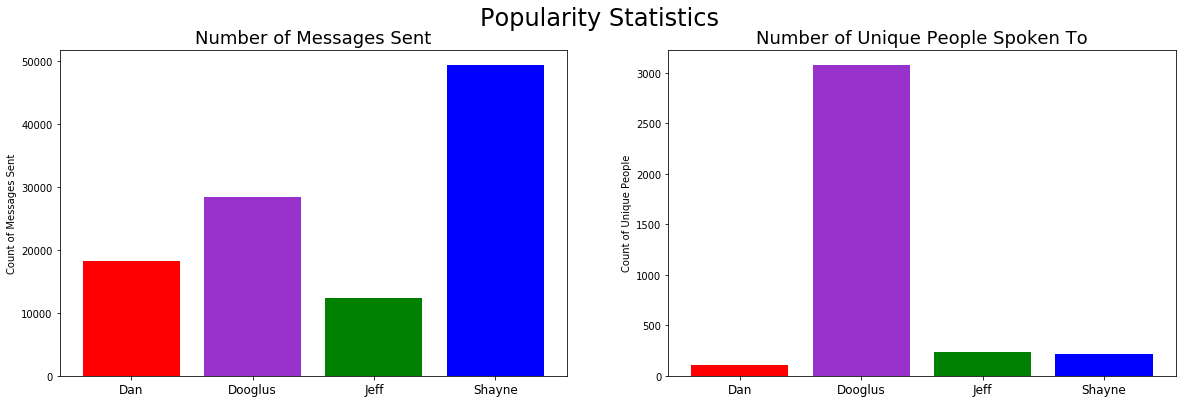

In [11]:
### Plot how many messages we've each sent ###
sent_messages_dict = {}
for i, df in enumerate(dataframe_list):
    sent_messages_dict[person_list[i]] = df[df['sender']==person_list[i]].shape[0]
    
### Plot the number of unique folks we've spoken to ###
unique_folks_dict = {}
for i, df in enumerate(dataframe_list):
    unique_folks_dict[person_list[i]] = len(df['recipient'].unique())-1

dict_ = sent_messages_dict

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('Popularity Statistics', fontsize=24)
plt.setp(axes, xticks=range(len(dict_)), xticklabels=list(dict_.keys()))
axes[0].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='x', labelsize=12)
axes[0].bar(range(len(sent_messages_dict)), list(sent_messages_dict.values()), align='center', color=color_list)
axes[0].set_title("Number of Messages Sent", fontsize=18)
axes[0].set_ylabel("Count of Messages Sent")
axes[1].bar(range(len(unique_folks_dict)), list(unique_folks_dict.values()), align='center', color=color_list)
axes[1].set_title("Number of Unique People Spoken To", fontsize=18)
axes[1].set_ylabel("Count of Unique People")
plt.show()

From these graphs we can see that Shayne sends the most messages, though before drawing any conclusions we have to considor some factors:
- Though we pulled the sources that each person uses to communicate, we are not normalizing for any kind of timeframe. Dan and Shayne's SMS data was pulled from how long he had their current phones, with no obvious way to acquire the SMS data from older phones
- This also only captures pure count of messages sent. This does not account for instances when a person sends a one word message, or back-to-back one word messages for emphasis, something that Shayne admittadly does frequently.

It is no surprise that the Dooglus dataset has an order of magnitude more considering that dataset was pulled from an online forum where Dooglus is having very short interactions with many different people.

### Part 2.2: Message Statistics
Here we will explore:
- Average Length of Messages
- Unique Words Used

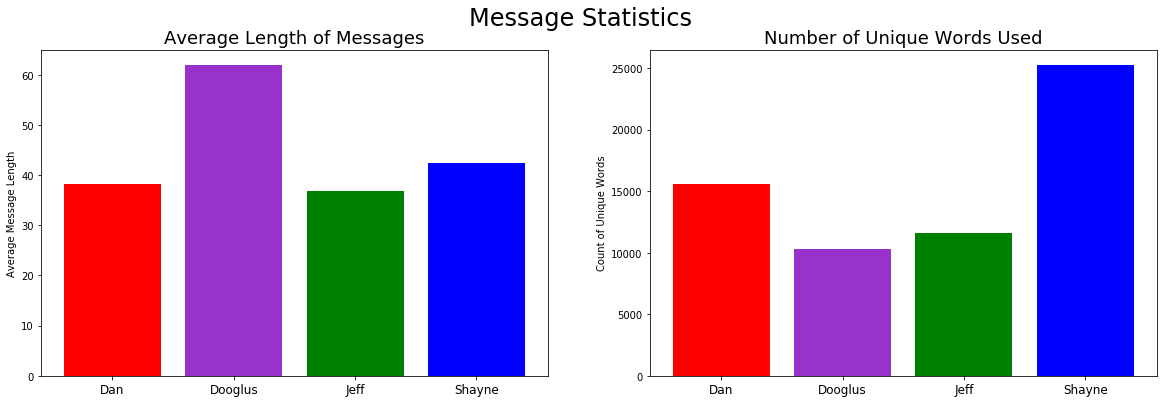

Wall time: 2min 11s


In [12]:
%%time

### Helper Function to tokenize a Pandas Dataframe column
def tokenizeMessage(text):
    word_list = nltk.word_tokenize(text)
    return [word.lower() for word in word_list if word.isalpha()]

### Plot the Average Length of each text ###
length_messages_dict = {}
for i, df in enumerate(dataframe_list):
    mean_length_df = df.groupby('sender')['message'].apply(lambda x: np.mean(x.str.len())).reset_index(name='mean_len_text')
    length_messages_dict[person_list[i]] = mean_length_df[mean_length_df['sender'] == person_list[i]]['mean_len_text'].iloc[0]
    
### Plot the number of unique words used ###
unique_words_dict = {}
# temp_df = pd.DataFrame()
for i, df in enumerate(dataframe_list):
    df['tokenized_sents'] = df['message'].apply(tokenizeMessage)
    unique_words_dict[person_list[i]] = len(df['tokenized_sents'].apply(pd.Series).stack().value_counts())
    

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('Message Statistics', fontsize=24)
plt.setp(axes, xticks=range(len(length_messages_dict)), xticklabels=list(length_messages_dict.keys()))
axes[0].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='x', labelsize=12)
axes[0].bar(range(len(length_messages_dict)), list(length_messages_dict.values()), align='center', color=color_list)
axes[0].set_title("Average Length of Messages", fontsize=18)
axes[0].set_ylabel("Average Message Length")
axes[1].bar(range(len(unique_words_dict)), list(unique_words_dict.values()), align='center', color=color_list)
axes[1].set_title("Number of Unique Words Used", fontsize=18)
axes[1].set_ylabel("Count of Unique Words")
plt.show()

Average length of messages is an interesting way to look at how much content we send with each message. The average is capturing all of the one word messages we send, balanced out by instances when we copy/paste long messages. It's note surprising to see that we each send messages of similar length when averaged, as we share similar texting styles brought about by years of instant messaging. The Dooglus dataset does pull ahead, probably due to the fact that he is trying to provide instruction typically, so more words are necessary. 

A look a unique words used is inherently biased because we are not taking any steps to remove typos at this point. Barring that, and assuming we each have the same propensity to err while typing, it was not surprising that Shayne had many more words given his ability to communicate in 2 languages and his tendency to frequently make up new words. 

#### Lets investigate the length of words a bit more to see if we can see how much the outliers we mentioned affect that average:

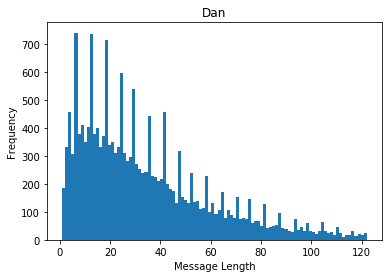

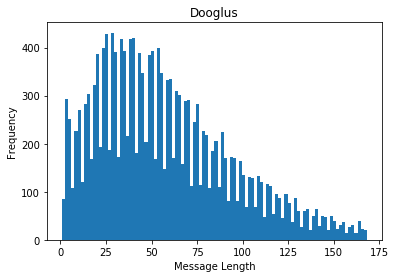

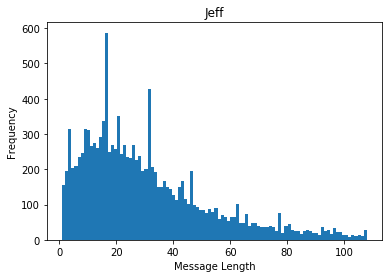

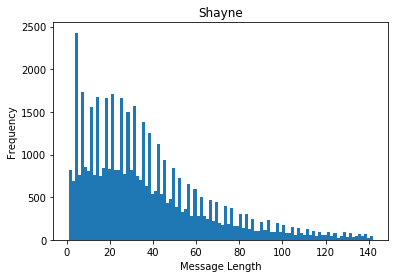

In [13]:
### Showing Distribution of message length ###
pd.set_option('mode.chained_assignment', None)
master_df = master_df[~master_df.message.str.contains("Jeff just played")]

### Looking only at messages that we have sent
sender_data = master_df[master_df.sender.isin(person_list)]
sender_data['clean_message'] = sender_data.message.str.replace(r'^https?:\/\/.*[\r\n]*', '')
pd.set_option('mode.chained_assignment', 'warn')

dummy = sender_data.copy()
for person in person_list:
    y = dummy[dummy.sender == person].message.str.len()
    newy = sorted(y.values)[:int(len(y)*0.97)]
    plt.hist(newy, bins = 100)
    plt.title(person)
    plt.xlabel("Message Length")
    plt.ylabel("Frequency")
    plt.show()

These distributions reveal more than just the simple averages were able to. We see that the message length's all have long, trailing tails toward longer messages. We expect these tails as the goal of "instant messaging" is to send quick thoughts/requests/etc. though there are clearly exceptions. In fact when we initially ran this each of us had outlier messages with length's in the thousands that we had to remove because it distorted these graphs so much.

#### Now let's display a word cloud to see which words we use most often:

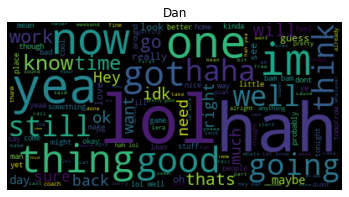

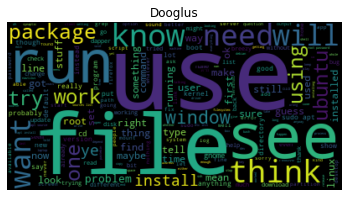

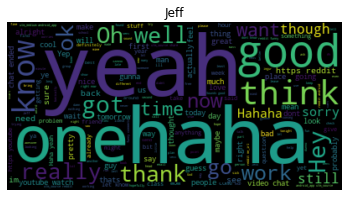

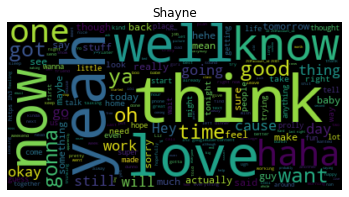

In [14]:
for person in person_list:
    wordcloud = WordCloud(stopwords=STOPWORDS).generate(" ".join(master_df[master_df.sender==person].message.values))
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(person)
    plt.axis("off")
    plt.show()

Though these word clouds are more of a fun exercise in analyzing our most frequently used words, they do give us our first step in being able to reveal if the person we're talking to is actually who they say they are. We can see that Dooglus' frequntly uses words related to computing and ubuntu (even ubuntu itself showed up!). This is to be expected given the origin of the data. A quick glance at the three of our word clouds reveal that we like to laugh and seem generally positive in our word usage. Let's take a deeper dive into the idea of message sentiment in Part 3!

<a id='Part3'></a>
##  Part 3: Analyzing Conversation Sentiment
[*top of page*](#Top) 

Now that we've done some exploration into what our data looks like, we can have some fun with it! Before moving on to classifying which speaker is talking, we wanted to run a sentiment analysis on each of our speaking behavoirs. This can be tangentially useful when trying to determine if the user of your chatbot is who they claim to be, but it can also have many other applications. One example that we discovered was just the applicability of reflecting on the tone we use when we communicate. While we were admittedly using out of the box packages with no labelled sentiment, we each still found the results of our sentiment scores very interesting. There is a large market for users that are constantly looking for self-improvement and wellness apps and, with more training, we believe there is a potential for this kind of "conversational tone analysis." Individuals can assess their speech patterns and recognize if they should be more cognizant of how they address their freinds, family and peers.

#### To start we use an instance of the SentimentIntensityAnalyzer class to quantify the sentiment of each message per sender. 

In [15]:
%%time
analyzer = SentimentIntensityAnalyzer()

pd.set_option('mode.chained_assignment', None)
sentiment_dfs = []

for i in range(len(person_list)):
    establishSentDF = dataframe_list[i]
    establishSentDF['sentiment'] =  establishSentDF.message.apply(lambda x: analyzer.polarity_scores(x))
    establishSentDF['sentiment_pos'] = establishSentDF['sentiment'].apply(lambda x: x['pos'])
    establishSentDF['sentiment_neg'] = establishSentDF['sentiment'].apply(lambda x: x['neg'])
    establishSentDF['sentiment_neu'] = establishSentDF['sentiment'].apply(lambda x: x['neu'])
    establishSentDF['sentiment_comp'] = establishSentDF['sentiment'].apply(lambda x: x['compound'])
    sentiment_dfs.append(establishSentDF)
    
pd.set_option('mode.chained_assignment', 'warn')

Wall time: 30.3 s


It is now easy to quantify how positive,negative, and neutral a given person's messages are on average

We also show the average compound summary score per sender. According to the [vader documentation](https://github.com/cjhutto/vaderSentiment), this value is meant to be a single summary value you could use to quantify if a message was positive or not. The value ranges from -1 to 1, with values >0.05 meaning a positive message, and values < -0.05 being negative. The window in the middle is neutral

In [16]:
for i in range(len(person_list)):
    singleEmotions = sentiment_dfs[i]
    singleEmotions = (np.sum(singleEmotions[['sentiment_pos','sentiment_neg','sentiment_neu','sentiment_comp']])/len(singleEmotions))*100
    singleEmotions['sentiment_comp'] = singleEmotions['sentiment_comp']/100 
    print(person_list[i] + "'s emotions:")
    print(singleEmotions, "\n")

Dan's emotions:
sentiment_pos     18.544413
sentiment_neg      7.019758
sentiment_neu     74.151402
sentiment_comp     0.123612
dtype: float64 

Dooglus's emotions:
sentiment_pos     10.738051
sentiment_neg      4.864273
sentiment_neu     84.223673
sentiment_comp     0.060167
dtype: float64 

Jeff's emotions:
sentiment_pos     18.941121
sentiment_neg      6.746571
sentiment_neu     73.882257
sentiment_comp     0.126354
dtype: float64 

Shayne's emotions:
sentiment_pos     18.272260
sentiment_neg      6.643222
sentiment_neu     74.807174
sentiment_comp     0.132352
dtype: float64 



#### Instead, lets look at how each sender speaks to an individual on average. Are they generally nice to everyone they speak to, no matter how long their conversation is?

This function calculates average sentiment per reciever

In [17]:
def perRecip(dataPerson):
    RecSent = {}

    sentCols = ['sentiment_pos','sentiment_neg','sentiment_neu', 'sentiment_comp']
    for reciever in set(dataPerson.recipient):
        vals = (np.sum(dataPerson[dataPerson['recipient']==reciever][sentCols])/len(dataPerson[dataPerson['recipient']==reciever]))*100
        vals['sentiment_comp'] = vals['sentiment_comp']/100
        RecSent[reciever] = vals

    pos_count = 0
    neg_count = 0
    neut_count = 0

    for person in RecSent.keys():
        vals = RecSent[person]
        sent = vals['sentiment_comp']
        if(sent >= 0.05):
            pos_count += 1
        elif(sent <= -0.05):
            neg_count += 1
        else:
            neut_count += 1

    print("pos perc: " + str(pos_count/len(RecSent.keys())*100))
    print("neg perc: " + str(neg_count/len(RecSent.keys())*100))
    print("neut perc: " + str(neut_count/len(RecSent.keys())*100))

    ConLen = len(RecSent.keys())
    Percs = [pos_count/ConLen*100, neg_count/ConLen*100, neut_count/ConLen*100]
    return Percs

#### We can now run and take a look at how each of our senders behaves on average

In [18]:
allRecipsDfs = []

for i in range(len(person_list)):
    print(person_list[i] + "'s data: ")
    allRecipsDfs.append(perRecip(sentiment_dfs[i]))
    print()

Dan's data: 
pos perc: 76.36363636363637
neg perc: 6.363636363636363
neut perc: 17.272727272727273

Dooglus's data: 
pos perc: 35.41260558804418
neg perc: 15.95191682910981
neut perc: 48.635477582846

Jeff's data: 
pos perc: 75.84745762711864
neg perc: 8.050847457627118
neut perc: 16.101694915254235

Shayne's data: 
pos perc: 81.01851851851852
neg perc: 4.62962962962963
neut perc: 14.351851851851851



#### A visualization makes this easier to interpret

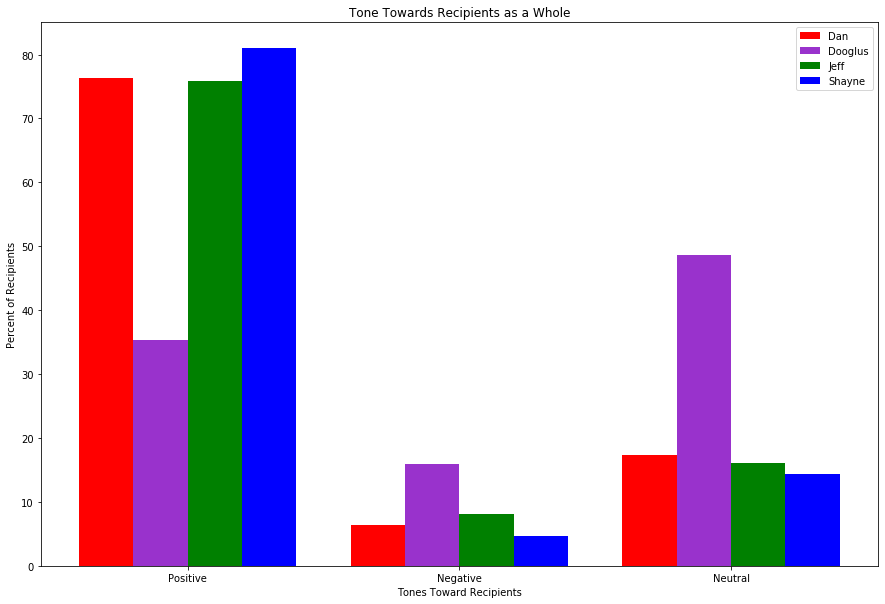

None


In [19]:
N = len(person_list)

ind = np.arange(3)  # the x locations for the groups
width = 1/(N+1)       # the width of the bars

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)


for i in range(len(person_list)):
    totWidth = ind
    if i != 0:
        totWidth = totWidth + (i*width)
    data = allRecipsDfs[i]
    rects = ax.bar(totWidth, data, width ,color=color_list[i])


# add some
ax.set_ylabel('Percent of Recipients')
ax.set_xlabel("Tones Toward Recipients")
ax.set_title('Tone Towards Recipients as a Whole')
ax.set_xticks(ind + (width*(.5 + (width*(N+1)))))
ax.set_xticklabels( ('Positive', 'Negative', 'Neutral') )

ax.legend(person_list)

print(plt.show())

We can see that on average, the three groupmates were pretty positive with their messages, while the Dooglus dataset was most often nuetral. This is to be expected as that dataset came from an online forum designed to provide technical support and it seems Dooglus was able to stay composed in most of his discourse.

#### Now, we can look at the average tone of the messages being sent by user. This time however lets take a look using the summary statistic we mentioned earlier

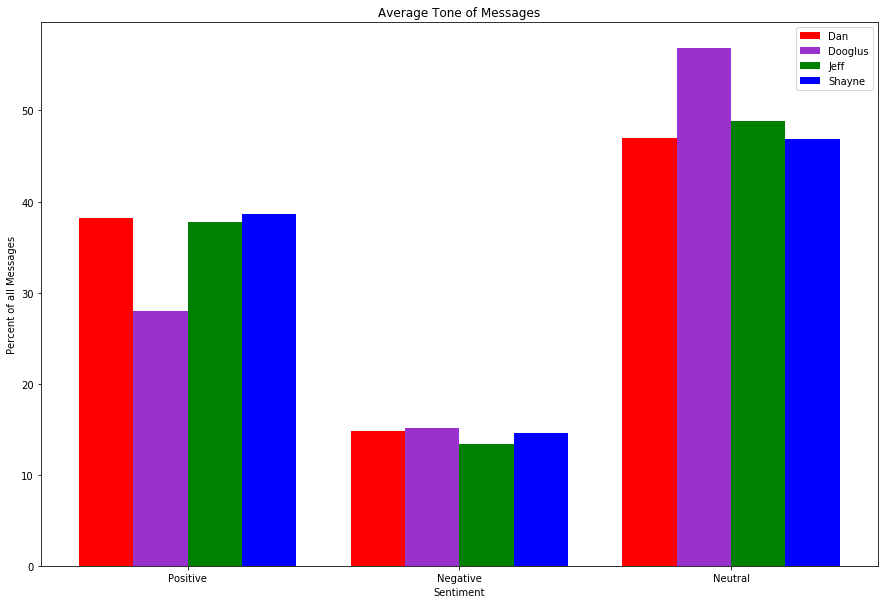

None


In [20]:
overallSentSummaryDfs = []
for i in range(len(person_list)):
    overallSent = sentiment_dfs[i]['sentiment_comp'].apply(lambda x: 1 if x >= 0.05 else (-1 if x <= -0.05 else 0))
    sentSum = [sum(overallSent == 1),sum(overallSent == -1),sum(overallSent == 0)]
    sentSum = np.asarray(sentSum)/len(overallSent)*100
    overallSentSummaryDfs.append(sentSum)


N = len(person_list)

ind = np.arange(3)  # the x locations for the groups
width = 1/(N+1)       # the width of the bars

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)


for i in range(len(person_list)):
    totWidth = ind
    if i != 0:
        totWidth = totWidth + (i*width)
    rects = ax.bar(totWidth, overallSentSummaryDfs[i], width ,color=color_list[i])

# add some
ax.set_ylabel('Percent of all Messages')
ax.set_xlabel("Sentiment")
ax.set_title('Average Tone of Messages')
ax.set_xticks(ind + (width*(.5 + (width*(N+1)))))
ax.set_xticklabels( ('Positive', 'Negative', 'Neutral') )

ax.legend(person_list)

print(plt.show())

This chart differs from the first in that the first displayed the aggregated average sentiment per individual and the second was the average sentiment across all messages sent by one of the participants. We can interpret this combination of charts by saying each of the three group members tend to be positive in general, but because their positivity score drops in the second graph, this implies that they are less positive to individuals that they speak to frequently. 

<a id='Part3.5'></a>
##  Part 4: Verifying the Validity of a Speaker
[*top of page*](#Top) 

In Part 4 we arrive at the meat of our problem. With Chatbots gaining more and more power over our sensitive personal information, individuals and institutions need to be sure that the person interacting with the chatbot is really a verified user. Credentials can be stolen, so using our user verification tool will allow institutions to add another layer of protection for their users. In practice, this would mean a chatbot will analyze the inputs of a user and cross-reference those inputs with historical data to ensure that the individual is really who they say they are. In this project, we used our compiled data to train a variety of classification models to predict which of the 4 participants is speaking given test inputs. To replicate this step of the process, look for the iceroot.pkl and the gnomefreak.pkl to add two additional personas to the mix.

In [114]:
### Limiting the dataset down to only messages we've sent
sender_data = pd.DataFrame(columns = dataframe_list[0].columns)

for df in dataframe_list:
    for p in person_list:
        sender_data = pd.concat((sender_data,df[df.sender == p]))
sender_data.shape

### Removing all of the words with friends messages that permeate Jeff's conversations
## (This was drastically throwing off the results of the models)
sender_data = sender_data[ ~sender_data.message.str.contains("Jeff just played")]

### Removing hyperlinks and limiting our messages to above 10 characters (it's hard to guess who said one word replies)
sender_data['clean_message'] = sender_data.message.str.replace(r'^https?:\/\/.*[\r\n]*', '')
sender_data["message len"] = sender_data.clean_message.str.len()
sender_data_min_len = sender_data[sender_data['message len']>10]
pd.set_option('mode.chained_assignment', 'warn')

datasets = []
minlen = np.inf
for keys in person_list:
    if minlen > len(sender_data_min_len[sender_data_min_len.sender == keys]):
        minlen = len(sender_data_min_len[sender_data_min_len.sender == keys])
        
    datasets.append(sender_data_min_len[sender_data_min_len.sender == keys])

balanced_df = pd.DataFrame(columns = sender_data_min_len.columns)
for d in datasets:
    balanced_df = pd.concat((balanced_df,d.sample(minlen)))
print(minlen,balanced_df.shape)

C:\Users\Punst\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


9403 (37612, 6)


### Part 4.1: Splitting the data into train and test subsets

In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
X = vectorizer.fit_transform(balanced_df.clean_message)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, balanced_df.sender, test_size=0.33, random_state=42)

message_test = balanced_df.message[y_test.index].values
message_train = balanced_df.message[y_train.index].values

### Part 4.2: Random Forest Classifier

In [116]:
%%time
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()

from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[50,100,500,1000], 'max_depth':[5, 10,100,500,1000,None]}
gs_rf_clf = GridSearchCV(rf_clf, parameters, n_jobs=-1, verbose = 1, refit = True, cv = 5)
gs_rf_clf.fit(X_train, y_train)

print("best params",gs_rf_clf.best_params_)

rf_pred = gs_rf_clf.predict(X_test)
print("RandomForest",np.mean(rf_pred == y_test))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 29.0min finished


best params {'max_depth': 500, 'n_estimators': 500}
RandomForest 0.6295520464067031
Wall time: 31min 58s


### Part 4.3: Support Vector Machine Classifier

In [117]:
%%time
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
svc_clf = SVC(gamma = 'scale', probability=True, C = 200)
parameters = {'C': [300, 350,400,450,500]}
gs_rf_clf = GridSearchCV(svc_clf, parameters, n_jobs=-1,refit = True,verbose = 1, cv=5)
gs_rf_clf.fit(X_train,y_train)
svc_pred = gs_rf_clf.predict(X_test)

print("SVM",gs_rf_clf.best_params_,np.mean(svc_pred == y_test))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 41.9min finished


SVM {'C': 300} 0.6879632613599742
Wall time: 54min 13s
Parser   : 369 ms


### Part 4.4: Naive Bayes Classifier

In [118]:
%%time
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train.toarray(),y_train)
gnb_pred = gnb.predict(X_test.toarray())
np.mean(gnb_pred == y_test)

Wall time: 4.76 s


0.5838704479535933

### Part 4.5: K Nearest Neighbors Classifier

In [119]:
%%time
from sklearn.neighbors import KNeighborsClassifier
best_k = None
best_score = -np.inf
for k in range(1,15,2):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train,y_train)
    neigh_pred = neigh.predict(X_test)
    score = np.mean(neigh_pred == y_test)
    if best_score < score:
        best_score=score
        best_k = k
print(best_k,best_score)

neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(X_train,y_train)

1 0.4671285852400902
Wall time: 1min 2s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

### Part 4.6: Long Short-Term Memory RNN

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim 
from gensim.models import Word2Vec 
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 100
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(balanced_df.message)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
X_lstm = tokenizer.texts_to_sequences(balanced_df.message)
X_lstm = pad_sequences(X_lstm, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_lstm.shape)
Y_lstm = pd.get_dummies(balanced_df.sender).values
print('Shape of label tensor:', Y_lstm.shape)

from sklearn.model_selection import train_test_split
X_train_lstm, X_test_lstm, Y_train_lstm, Y_test_lstm = train_test_split(X_lstm,Y_lstm, test_size = 0.10, random_state = 42)
x_clear_train, x_clear_test, y_clear_train, y_clear_test = train_test_split(balanced_df.message,balanced_df.sender, test_size = 0.10, random_state = 42)
print(X_train_lstm.shape,Y_train_lstm.shape)
print(X_test_lstm.shape,Y_test_lstm.shape)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_lstm.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(person_list), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 3
batch_size = 64

history = model.fit(X_train_lstm, Y_train_lstm, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Found 20265 unique tokens.
Shape of data tensor: (37612, 100)
Shape of label tensor: (37612, 4)
(33850, 100) (33850, 4)
(3762, 100) (3762, 4)
Train on 30465 samples, validate on 3385 samples
Epoch 1/3
30465/30465 [==============================] - 101s 3ms/sample - loss: 0.9638 - accuracy: 0.5636 - val_loss: 0.7253 - val_accuracy: 0.6999
Epoch 2/3
30465/30465 [==============================] - 99s 3ms/sample - loss: 0.6282 - accuracy: 0.7419 - val_loss: 0.6594 - val_accuracy: 0.7185
Epoch 3/3
30465/30465 [==============================] - 100s 3ms/sample - loss: 0.5021 - accuracy: 0.8026 - val_loss: 0.6727 - val_accuracy: 0.7253


In [128]:
lstm_pred = model.predict(X_test_lstm)
print("LSTM",np.mean(lstm_pred.argmax(axis = 1) == Y_test_lstm.argmax(axis = 1)))

LSTM 0.7174375332270069


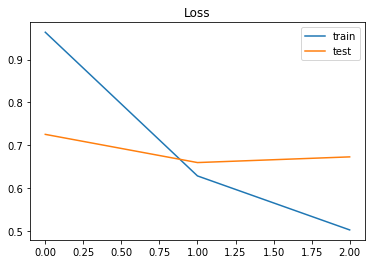

In [129]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [130]:
lstm_pred_proba = model.predict_proba(X_test_lstm)

In [131]:
sender_table = lstm_pred_proba.argsort(axis = 0)[-3:][::-1]
# sender_table
x_clear_text = x_clear_test.values

With the LSTM trained, we are able to highlight certain phrases that are distinct to each of the participants. As you can see Dooglus' phrases focus on content in the IT world given the nature of that particular dataset. Similarly, Shayne's phrases are the kind that make you want to vomit because he's a big softy.

In [132]:
for i,person in enumerate(person_list):
    print(person)
    for j in sender_table[:,i]:
        print(x_clear_text[j])
    print()

Dan
yea i would also agree hah
Yea why not hah
Lol well it was one of your first big things itll get better hah

Dooglus
md5sum /var/lib/apt/lists/*_ubuntu_dists_breezy-updates_Release*   ?
I'm not clear how to build a kernel package that has the same contents as the ubuntu kernel package
dapper?  i386?  desktop?  http://snurl.com/dapper

Jeff
Ah gotcha gotcha
It's a really nice place actually! The food is incredible
Hahaha that stinks

Shayne
Don't think you're gonna get along with Brian?
I am hoping to go back to Mbengwi a couple times while I'm in Cameroon
but it's right around the commons so it'll prolly be 15$



<a id='Part5'></a>
## Part 5: Testing the Verification Tool
[*top of page*](#Top)

Now that the models have been trained we have created a tool that will allow users to input their own text and see which users are most likely to have said that phrase. This is just one implementation of the verification tool, in practice institutions would acquire a corpus of previous conversations with their customers or friends/family and use this to train the verification models. From there they could have a process running in the background that could warn them if the user on the other end is showing signs of being an imposter by not following their typical patterns of communication. 

In [126]:
test_input = 'begin'

while(test_input !='exit'):
    
    test_input =input("Enter Message you want to test ('exit' to quit):")
    if test_input != "exit":
        print("Input",test_input)
        x_message = vectorizer.transform([test_input])    
        print("RandomForest",gs_rf_clf.predict(x_message)[0])
        print("Svm",gs_rf_clf.predict(x_message)[0])
        print("Knn",neigh.predict(x_message)[0])
        print("NB", gnb.predict(x_message.toarray())[0])
        X_lstm_message = tokenizer.texts_to_sequences([test_input])
        X_lstm_message = pad_sequences(X_lstm_message, maxlen=MAX_SEQUENCE_LENGTH)
        print("LSTM",person_list[model.predict(X_lstm_message).argmax()])
        print()
    else:
        print("Goodbye")

    

Enter Message you want to test ('exit' to quit):Wow, I think we're done with our final Practical Data Science Project!
Input Wow, I think we're done with our final Practical Data Science Project!
RandomForest Jeff
Svm Jeff
Knn Shayne
NB Jeff
LSTM Jeff

Enter Message you want to test ('exit' to quit):exit
Goodbye


## Conclusion

The continuation of this project (which can also be found on the Github repo) is the implemenation of our own chatbot built using our own dialogue corpus. The downside of this bot is that we didn't have nearly enough data to train it properly with our individual datasets, and (probably) not even with our combined datasets. Our plan is to continue iterating through the design process and hopefully have a bot in the future that captures the unique combination of each of our personalities!

In the meantime this project was a great way for us to analyze our digital speaking habits and gain insight into the tone we use when conversing with others online. As technology continues to play such a central role in our society, it is important for us to understand how criminals can try to take advantage of new innovations so we can disrupt their efforts to sow discord. The verification tool that we have developed is a rudimentary prototype that can be used as the groundwork to identify if the person you're interacting with online is actually friend or foe.

Thank you,

The Chatting with Yourself team